In [19]:
from fastcore.xtras import load_pickle
import pandas as pd 
import os 
from glob import glob
import matplotlib.pyplot as plt
from datetime import datetime
import ast

import sys
sys.path.append("/home/jorenvanherck/Documents/gptchallengeV2/gptchem-gptj/plotutils/")
from plotutils import *

plt.style.use("/home/jorenvanherck/Documents/gptchallengeV2/gptchem-gptj/plotutils/kevin.mplstyle")

FOLDER = 'out'

In [20]:
if not os.path.exists(FOLDER):
    raise FileExistsError('Cannot find folder {}'.format(FOLDER))

all_res = glob(f'{FOLDER}/*.pkl')
print('Pickles found in {}: {}'.format(FOLDER, len(all_res)))

Pickles found in out: 12


In [21]:

compiled_res_list = []
conf_mats = []

for results in all_res:
    res_full = load_pickle(results)
    res = res_full['results']
    summary = {
        'size': res_full['train_size'],
        #'representation': res_full['data_summary']['representation'],
        'target': res_full['data_summary']['target'],
        'accuracy': res['accuracy'],
        'f1_macro': res['f1_macro'],
        'f1_micro': res['f1_micro'],
        'kappa': res['kappa'],
        'num_epochs': res_full['config']['tune_settings']['num_train_epochs'],
        'lr': res_full['config']['tune_settings']['learning_rate'],
        'bins': len(set(res['all_y_true'])),
        'test_size': len(res['all_y_true'])
       
    }
    confusion_matrix = {
        'all_y_true':res['all_y_true'],
        'all_y_pred':res['all_y_pred']
    }
    conf_mats.append(confusion_matrix)
    compiled_res_list.append(summary)

In [22]:
compiled_res = pd.DataFrame(compiled_res_list)
grouped_res =compiled_res.groupby(['bins', 'num_epochs', 'target', 'size']).agg(['mean', 'sem'])


In [23]:
grouped_res


accuracy            f1_macro            f1_micro  \
                                 mean       sem      mean       sem      mean   
bins num_epochs target size                                                     
2    4          y_bin  100   0.593333  0.048074  0.501586  0.085873  0.593333   
                       500   0.880000  0.020000  0.879006  0.020448  0.880000   
                       1000  0.900000  0.011547  0.899880  0.011566  0.900000   
                       5000  0.926667  0.035277  0.926487  0.035433  0.926667   

                                          kappa                lr       \
                                  sem      mean       sem    mean  sem   
bins num_epochs target size                                              
2    4          y_bin  100   0.048074  0.186667  0.096148  0.0003  0.0   
                       500   0.020000  0.760000  0.040000  0.0003  0.0   
                       1000  0.011547  0.800000  0.023094  0.0003  0.0   
                       5000  0.035277  0.853333  0.070553  0.0003  0.0   

                            test_size       
                                 mean  sem  
bins num_epochs target size                 
2    4          y_bin  100       50.0  0.0  
                       500       50.0  0.0  
                       1000      50.0  0.0  
                       5000      50.0  0.0

# Plot

In [24]:
def add_traditional_ml(ax, modeltypes = ['RandomForestClassifier']):
    df_ml_all = pd.read_csv('../ml/AdE_polymers_trad_ml.csv')
    for modeltype in modeltypes:
        df_ml = df_ml_all.loc[df_ml_all['modeltype'] == modeltype][['modeltype','target','train_size','accuracy','f1_macro','f1_micro','kappa']]
        df_ml_grouped =df_ml.groupby(['modeltype', 'target', 'train_size']).agg(['mean', 'sem'])
        display(df_ml_grouped)

        for i, metric in enumerate(['accuracy', 'f1_macro', 'f1_micro', 'kappa']):
            ax[i].plot(
                grouped_res.loc[BINS, num_epochs,REPRESENTATION].index, 
                grouped_res.loc[BINS, num_epochs,REPRESENTATION][metric]['mean'],
                marker='o',
                label=f'{num_epochs} epochs',
                c = 'red',
                alpha = 0.3
            )
            ax[i].fill_between(
                grouped_res.loc[BINS, num_epochs,REPRESENTATION].index,
                grouped_res.loc[BINS, num_epochs,REPRESENTATION][metric]['mean'] - grouped_res.loc[BINS, num_epochs,REPRESENTATION][metric]['sem'],
                grouped_res.loc[BINS, num_epochs,REPRESENTATION][metric]['mean'] + grouped_res.loc[BINS, num_epochs,REPRESENTATION][metric]['sem'],
                alpha=0.1
            )
    return ax

accuracy            f1_macro            f1_micro  \
                                 mean       sem      mean       sem      mean   
bins num_epochs target size                                                     
2    4          y_bin  100   0.593333  0.048074  0.501586  0.085873  0.593333   
                       500   0.880000  0.020000  0.879006  0.020448  0.880000   
                       1000  0.900000  0.011547  0.899880  0.011566  0.900000   
                       5000  0.926667  0.035277  0.926487  0.035433  0.926667   

                                          kappa                lr       \
                                  sem      mean       sem    mean  sem   
bins num_epochs target size                                              
2    4          y_bin  100   0.048074  0.186667  0.096148  0.0003  0.0   
                       500   0.020000  0.760000  0.040000  0.0003  0.0   
                       1000  0.011547  0.800000  0.023094  0.0003  0.0   
                       5000  0.035277  0.853333  0.070553  0.0003  0.0   

                            test_size       
                                 mean  sem  
bins num_epochs target size                 
2    4          y_bin  100       50.0  0.0  
                       500       50.0  0.0  
                       1000      50.0  0.0  
                       5000      50.0  0.0

accuracy            f1_macro  \
                                              mean       sem      mean   
modeltype              target train_size                                 
RandomForestClassifier y_bin  100         0.740000  0.011547  0.728544   
                              500         0.813333  0.024037  0.810752   
                              1000        0.833333  0.029059  0.830792   
                              5000        0.900000  0.034641  0.899122   

                                                    f1_micro            \
                                               sem      mean       sem   
modeltype              target train_size                                 
RandomForestClassifier y_bin  100         0.016052  0.740000  0.011547   
                              500         0.025805  0.813333  0.024037   
                              1000        0.031316  0.833333  0.029059   
                              5000        0.035244  0.900000  0.034641   

                                             kappa            
                                              mean       sem  
modeltype              target train_size                      
RandomForestClassifier y_bin  100         0.459833  0.030764  
                              500         0.622615  0.051470  
                              1000        0.662655  0.062511  
                              5000        0.798904  0.070499

accuracy            f1_macro            \
                                     mean       sem      mean       sem   
modeltype     target train_size                                           
XGBClassifier y_bin  100         0.766667  0.033333  0.758914  0.030223   
                     500         0.846667  0.017638  0.845403  0.018502   
                     1000        0.886667  0.037118  0.884340  0.038476   
                     5000        0.940000  0.030551  0.938796  0.031511   

                                 f1_micro               kappa            
                                     mean       sem      mean       sem  
modeltype     target train_size                                          
XGBClassifier y_bin  100         0.766667  0.033333  0.519174  0.060836  
                     500         0.846667  0.017638  0.691366  0.037440  
                     1000        0.886667  0.037118  0.769453  0.076454  
                     5000        0.940000  0.030551  0.877775  0.062907

/home/jorenvanherck/.local/lib/python3.10/site-packages/matplotlib/ticker.py:2954: RuntimeWarning: invalid value encountered in log10
  majorstep_no_exponent = 10 ** (np.log10(majorstep) % 1)
/home/jorenvanherck/.local/lib/python3.10/site-packages/matplotlib/ticker.py:2954: RuntimeWarning: invalid value encountered in log10
  majorstep_no_exponent = 10 ** (np.log10(majorstep) % 1)


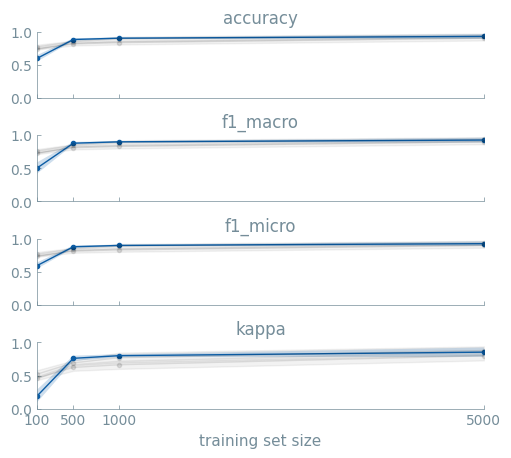

In [26]:
from scipy.stats import sem
from scipy.constants import golden
ONE_COL_WIDTH_INCH = 5
TWO_COL_WIDTH_INCH = 7.2

ONE_COL_GOLDEN_RATIO_HEIGHT_INCH = ONE_COL_WIDTH_INCH / golden
TWO_COL_GOLDEN_RATIO_HEIGHT_INCH = TWO_COL_WIDTH_INCH / golden

BINS = 2
REPRESENTATION = 'y_bin'

fig, ax = plt.subplots(4, 1,figsize=(ONE_COL_WIDTH_INCH, TWO_COL_GOLDEN_RATIO_HEIGHT_INCH),constrained_layout = True , sharex=True)
display(grouped_res)
for num_epochs in [4]:
    for i, metric in enumerate(['accuracy', 'f1_macro', 'f1_micro', 'kappa']):
        ax[i].plot(
            grouped_res.loc[BINS, num_epochs,REPRESENTATION].index, 
            grouped_res.loc[BINS, num_epochs,REPRESENTATION][metric]['mean'],
            marker='o',
            label=f'{num_epochs} epochs'
        )
        ax[i].fill_between(
            grouped_res.loc[BINS, num_epochs,REPRESENTATION].index,
            grouped_res.loc[BINS, num_epochs,REPRESENTATION][metric]['mean'] - grouped_res.loc[BINS, num_epochs,REPRESENTATION][metric]['sem'],
            grouped_res.loc[BINS, num_epochs,REPRESENTATION][metric]['mean'] + grouped_res.loc[BINS, num_epochs,REPRESENTATION][metric]['sem'],
            alpha=0.2
        )
        ax[i].set_ylim(0,1)
        #ax[i].set_title(metric)
        ax[i].set_xticks((list(compiled_res['size'].unique())))
        ax[i].set_title(metric)
    #ylabel_top('accuracy', ax=ax[0])
    #ylabel_top(r'F$_1$ macro', ax=ax[1])
    #ylabel_top(r'F$_1$ micro', ax=ax[2])
    #ylabel_top(r'$\kappa$', ax=ax[3])
ax[-1].set_xlabel('training set size')

def add_traditional_ml(ax, modeltypes = ['RandomForestClassifier', 'XGBClassifier'], target = 'y_bin'):
    df_ml_all = pd.read_csv('../ml/AdE_polymers_traditional_ml.csv')
    
    df_ml_all['target'] = [ ast.literal_eval(l)[0] for l in df_ml_all['target']]
    for modeltype in modeltypes:
        df_ml = df_ml_all.loc[df_ml_all['modeltype'] == modeltype][['modeltype','target','train_size','accuracy','f1_macro','f1_micro','kappa']]
        df_ml_grouped =df_ml.groupby(['modeltype', 'target', 'train_size']).agg(['mean', 'sem'])
        display(df_ml_grouped)

        for i, metric in enumerate(['accuracy', 'f1_macro', 'f1_micro', 'kappa']):
            ax[i].plot(
                df_ml_grouped.loc[modeltype,target].index, 
                df_ml_grouped.loc[modeltype,target][metric]['mean'],
                marker='o',
                label=f'{num_epochs} epochs',
                color = 'k',
                alpha = 0.1
            )
            ax[i].fill_between(
                df_ml_grouped.loc[modeltype,target].index,
                df_ml_grouped.loc[modeltype,target][metric]['mean'] - df_ml_grouped.loc[modeltype,target][metric]['sem'],
                df_ml_grouped.loc[modeltype,target][metric]['mean'] + df_ml_grouped.loc[modeltype,target][metric]['sem'],
                color = 'k',
                alpha=0.05
            )
    return ax

ax = add_traditional_ml(ax)

#matplotx.line_labels(ax[0])
now = datetime.now().strftime('%Y%m%d_%H%M') 
#fig.suptitle('Hydrides - {} - {}'.format(REPRESENTATION, 'binary'), fontsize=16)
fig.savefig(f'{now}_AdhesiveFreeE-{REPRESENTATION}-binary-{BINS}bin-classification-results.pdf', bbox_inches='tight')

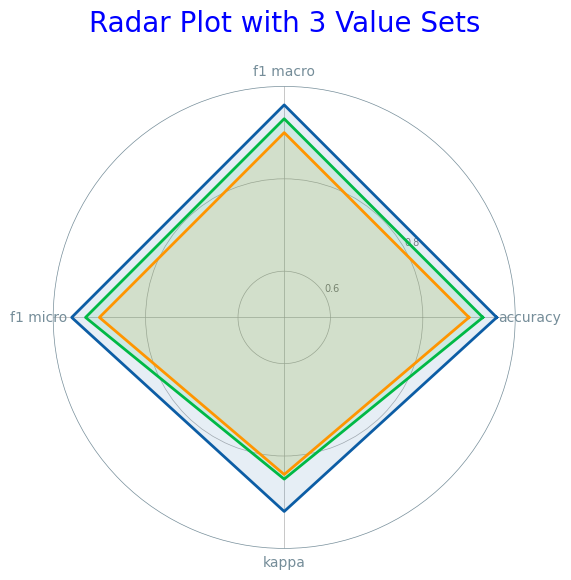

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from math import pi

# Function to create a radar chart with multiple values lists
def create_radar_chart_multiple(categories, values_list, title="Radar Plot"):
    N = len(categories)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    plt.figure(figsize=(6, 6))
    ax = plt.subplot(111, polar=True)
    
    plt.xticks(angles[:-1], categories)
    ax.set_rlabel_position(30)
    plt.yticks([0.2, 0.4, 0.6, 0.8], ["0.2", "0.4", "0.6", "0.8"], color="grey", size=7)
    plt.ylim(0.5, 1)

    for values in values_list:
        values += values[:1]  # Loop the values to close the chart
        ax.plot(angles, values, linewidth=2, linestyle='solid')
        ax.fill(angles, values, alpha=0.1)

    plt.title(title, size=20, color='blue', y=1.1)
    plt.show()

# Three categories
categories_3 = ['accuracy', 'f1 macro', 'f1 micro', 'kappa']

# Three different values lists
values_list_3 = [
    [0.96, 0.96, 0.96, 0.92],  # Llama
    [0.93, 0.93, 0.93, 0.85],  # Second set of values
    [0.9, 0.9, 0.9, 0.84]   # Mistral
]

# Creating radar chart with three sets of values
create_radar_chart_multiple(categories_3, values_list_3, "Radar Plot with 3 Value Sets")

